## Observations

In [1]:
using LinearAlgebra
using Plots

In [2]:
include("../rollout.jl")
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

In [3]:
BUDGET = 1

1

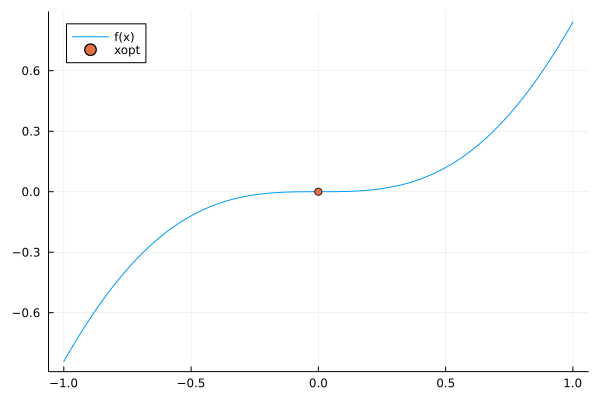

In [4]:
testfn = TestFunction(
    1,
    [-1. 1.],
    [0.],
    x -> (sin(first(x)) * first(x)^2),
    x -> [sin(first(x)) * 2first(x) + cos(first(x))*first(x)^2]
)
tplot(testfn)

In [5]:
n, h, σn2 = 1, 0, 1e-10
MC_SAMPLES = 10
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, h+1);
rns = randn(MC_SAMPLES, testfn.dim+1, h+1);

MAX_BUDGET, MAX_TRIALS = 25, 1
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [1.]
ψ = kernel_matern52(θ)

lbs, ubs = [xmin], [xmax]
ϵ, num_starts = 1e-6, 64
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

### Dense Experiments in 1D for Rollout Acquisition Functions
We'll do a comparative analysis, visually, of the structure of the rollout acquisition function in 1D for horizons 0 and 1.

In [6]:
struct RBFsurrogate2{Kernel<:RBFfun}
    ψ::Kernel
    # X::Matrix{Float64}
    # K::Matrix{Float64}
    # L::LowerTriangular{Float64, Matrix{Float64}}
    # y::Vector{Float64}
    # c::Vector{Float64}
    # σn2::Float64
    # ymean::Float64
end

In [7]:
typeof(RBFsurrogate2(ψ))

RBFsurrogate2{RBFfun}

In [8]:
X = [0.;;]
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
sur = fit_surrogate(ψ, X, y; σn2=σn2)

RBFsurrogate(RBFfun([1.0], var"#ψ#449"{var"#k#459", Vector{Float64}}(var"#k#459"(), [1.0]), var"#Dρ_ψ#450"{var"#ψ#449"{var"#k#459", Vector{Float64}}}(var"#ψ#449"{var"#k#459", Vector{Float64}}(var"#k#459"(), [1.0])), var"#Dρρ_ψ#451"{var"#Dρ_ψ#450"{var"#ψ#449"{var"#k#459", Vector{Float64}}}}(var"#Dρ_ψ#450"{var"#ψ#449"{var"#k#459", Vector{Float64}}}(var"#ψ#449"{var"#k#459", Vector{Float64}}(var"#k#459"(), [1.0]))), var"#∇θ_ψ#452"{var"#k#459", Vector{Float64}}(var"#k#459"(), [1.0])), [0.0;;], [1.0000000001;;], [1.00000000005;;], [0.0], [0.0], 1.0e-10, 0.0)

In [9]:
typeof(sur)

RBFsurrogate

In [10]:
struct RBFfun2{V<:AbstractVector}
    θ::V                # Hyperparameter vector
    ψ::Function                # Radial basis function
    Dρ_ψ::Function             # Derivative of the RBF wrt ρ
    Dρρ_ψ::Function            # Second derivative
    ∇θ_ψ::Function             # Gradient with respect to hypers
end

(rbf::RBFfun2)(ρ) = rbf.ψ(ρ)

function kernel_generic(k, θ)
    ψ(ρ) = k(ρ, θ)
    Dρ_ψ(ρ) = ForwardDiff.derivative(ψ, ρ)
    Dρρ_ψ(ρ) = ForwardDiff.derivative(Dρ_ψ, ρ)
    ∇θ_ψ(ρ) = ForwardDiff.gradient(θ -> k(ρ, θ), θ)
    return RBFfun2(θ, ψ, Dρ_ψ, Dρρ_ψ, ∇θ_ψ)
end

function kernel_scale(kfun::RBFfun2, θ::AbstractVector; kwargs...)
    s = θ[1]
    base_rbf = kfun(θ[2:end]; kwargs...)
    ψ(ρ)     = s * base_rbf.ψ(ρ)
    Dρ_ψ(ρ)  = s * base_rbf.Dρ_ψ(ρ)
    Dρρ_ψ(ρ) = s * base_rbf.Dρρ_ψ(ρ)
    ∇θ_ψ(ρ)  = vcat([base_rbf.ψ(ρ)], s * base_rbf.∇θ_ψ(ρ))
    return RBFfun2(θ, ψ, Dρ_ψ, Dρρ_ψ, ∇θ_ψ)
end

function kernel_matern52(θ=[1.])
    function k(ρ, θ)
        l = θ[1]
        c = sqrt(5.0) / l
        s = c*ρ
        return (1+s*(1+s/3.0))*exp(-s)
    end
    return kernel_generic(k, θ)
end

kernel_matern52 (generic function with 2 methods)

In [11]:
fk = () -> 1 + 1
RBFfun2([1.], fk, fk, fk, fk)

RBFfun2{Vector{Float64}}([1.0], var"#728#729"(), var"#728#729"(), var"#728#729"(), var"#728#729"())

In [13]:
@time typeof(RBFfun2([1.], fk, fk, fk, fk))

  0.000292 seconds (2 allocations: 112 bytes)


RBFfun2{Vector{Float64}}

In [54]:
function counter(start)
    counter = start
    
    function increment()
        counter += 1
        return counter
    end

    function decrement()
        counter -= 1
        return counter
    end

    function reset()
        counter = start
        return counter
    end

    function peek()
        return counter
    end
    
    
    return (inc=increment, dec=decrement, reset=reset, peek=peek)
end

counter (generic function with 1 method)